In [34]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import esmlab
from cycler import cycler
import palettable

In [2]:
def _load(p):
    ds = xr.open_dataset(p)
    dv = ds.data_vars
    if 'pr' in dv:
        return dv['pr']
    elif 'PRECT' in dv:
        return dv['PRECT']
    else:
        raise IOError("Could not find pr or PRECT")

In [3]:
def mm2inches(x):
    return x * 0.0393701

In [38]:
#
# We have 3 pieces of information, each in its own file: zonal mean, quantiles, histogram
#
region_string = "tropical" # "nh_extratropics"  #  
p0 = Path("/Volumes/Glyph6TB/")
p1 = p0 / "CMIP6"
p2 = p0 / "cloud_locking"

models = {"CESM2": ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff', 'f-cntl', 'f-lock', 'c-cntl', 'c-lock'),
         'CNRM-CM6-1': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'IPSL-CM6A-LR': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'), 
         'MRI-ESM2-0': ('amip', 'amip-lwoff')}


locking = {'f-cntl': 'F1850JJB_c201_CTL',
           'f-lock': 'F1850JJB_c201_CLOCK', 
           'c-cntl': 'B1850_c201_CTL',
           'c-lock': 'B1850_c201_CLOCK'}

use_member = {}
for m in models:
    if m == 'CNRM-CM6-1':
        use_member[m] = 'r1i1p1f2'
    else:
        use_member[m] = 'r1i1p1f1'

ZM = {}  # zonal mean
Q = {}  # quantiles
H = {}  # histogram
for m in models:
    ZM[m] = {}
    Q[m] = {}
    H[m] = {}
    for ex in models[m]:
        if ex in ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'):
            ZM[m][ex] = (86400.) * _load(p1 / "zonal_mean" / f'pr_day_{m}_{ex}_{use_member[m]}_ocean.nc')
            Q[m][ex] = (86400.) * _load(p1 / "quantiles" / f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc')
            H[m][ex] = _load(p1 / "histograms" / f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc')
        else:
            # case for locking
            ZM[m][ex] = (86400.*1000.) * _load(p2 / "zonal_mean" / f'PRECT_day_{locking[ex]}_ocean.nc')
            Q[m][ex] = (86400.*1000.) * _load(p2 / "quantiles" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')
            H[m][ex] = _load(p2 / "histograms" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')


            
# pcolors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors
pcolors = palettable.tableau.Tableau_20_r.mpl_colors
model_colors = {'CESM2' : {'aqua-control':0, 'aqua-control-lwoff':1, 'amip':0, 'amip-lwoff':1, 'f-cntl':8, 'f-lock':9, 'c-cntl':10, 'c-lock':11},
                'CNRM-CM6-1': {'aqua-control':2, 'aqua-control-lwoff':3, 'amip':2, 'amip-lwoff':3},
                'IPSL-CM6A-LR': {'aqua-control':4, 'aqua-control-lwoff':5, 'amip':4, 'amip-lwoff':5},
                'MRI-ESM2-0': {'amip':6, 'amip-lwoff':7}}         

CESM2 aqua
CESM2 aqua-lwoff
CNRM aqua
CNRM aqua-lwoff
IPSL aqua
IPSL aqua-lwoff


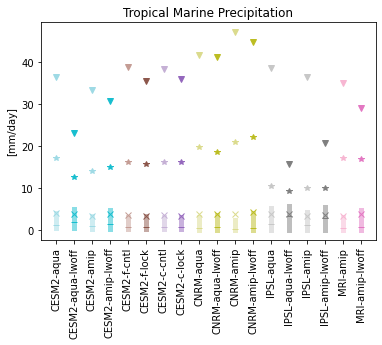

In [43]:
fig, ax = plt.subplots()
xpos = 1
xlab = []
for m in models:
    mnam = m.split('-')[0]
    for ex in Q[m]:
        exnam = ex
        if 'control' in exnam:
            exnam = exnam.replace('-control', '')
            print(mnam, exnam)
        ax.plot(xpos, Q[m][ex].sel(quantile=0.5), marker='_', color=pcolors[model_colors[m][ex]])
        ax.plot([xpos, xpos], [Q[m][ex].sel(quantile=0.25), Q[m][ex].sel(quantile=0.75)], color=pcolors[model_colors[m][ex]],
               linewidth=5, alpha=0.5)
        ax.plot(xpos, Q[m][ex].sel(quantile=0.95,method='nearest'), marker='*', color=pcolors[model_colors[m][ex]])
        ax.plot(xpos, Q[m][ex].sel(quantile=0.99, method='nearest'), marker='v', color=pcolors[model_colors[m][ex]])
        w = np.cos(np.radians((ZM[m][ex]['lat'])))
        a = esmlab.weighted_mean(ZM[m][ex].sel(lat=slice(-30,30)), dim=['lat'], weights=w.sel(lat=slice(-30,30)))
        ax.plot(xpos, a, marker='x', color=pcolors[model_colors[m][ex]])
        xpos += 1
        xlab.append("-".join([mnam,exnam]))
ax.set_xticks(np.arange(1, 19, 1))
ax.set_xticklabels(xlab, rotation=90)
xticks = ax.get_xticks()
ax.set_title("Tropical Marine Precipitation")
ax.set_ylabel("[mm/day]")
# ax.semilogy()
fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/lwoff_locking_precip_quasiboxplot.png", dpi=300, bbox_inches='tight')

In [36]:
ZM['CESM2']['aqua-control']

<xarray.DataArray 'pr' (lat: 192)>
array([ 1.3496381,  1.5461828,  1.5032146,  1.5017502,  1.5231164,
        1.517828 ,  1.5073012,  1.5005567,  1.5040356,  1.5001183,
        1.4972365,  1.4954088,  1.4973701,  1.4947166,  1.4921355,
        1.4917719,  1.4953467,  1.4968309,  1.5002656,  1.5042675,
        1.5072674,  1.5113845,  1.522282 ,  1.5404917,  1.5592828,
        1.5798016,  1.6029652,  1.6270299,  1.6550207,  1.691414 ,
        1.7303318,  1.7736444,  1.8247397,  1.8862332,  1.9621705,
        2.051321 ,  2.1535242,  2.2669685,  2.3897657,  2.521225 ,
        2.6583626,  2.798523 ,  2.940528 ,  3.0807366,  3.2163947,
        3.345302 ,  3.4606478,  3.5645194,  3.6588123,  3.7351553,
        3.780808 ,  3.7871723,  3.7554376,  3.687059 ,  3.585327 ,
        3.4510748,  3.2835758,  3.0935833,  2.8902647,  2.6798806,
        2.4667766,  2.258081 ,  2.0600626,  1.8780851,  1.7168949,
        1.582336 ,  1.4772856,  1.3936536,  1.332126 ,  1.2921699,
        1.2720463,  1.2698562,  1.2820281,  1.3056802,  1.3362851,
        1.3700529,  1.4021144,  1.4302104,  1.4494171,  1.4634335,
        1.4839425,  1.5268501,  1.6162113,  1.7836009,  2.0705266,
        2.5302713,  3.2357893,  4.2558336,  5.6587195,  7.450033 ,
        9.49603  , 11.432572 , 12.759115 , 13.127031 , 12.705966 ,
       12.193482 , 12.2021475, 12.713742 , 13.119113 , 12.735    ,
       11.385664 ,  9.4242735,  7.3665557,  5.5830364,  4.1953807,
        3.1875427,  2.4921708,  2.0316017,  1.7459552,  1.5823588,
        1.5006047,  1.4656386,  1.449836 ,  1.4407948,  1.4285369,
        1.408614 ,  1.3832741,  1.3534313,  1.3266648,  1.3083168,
        1.2989918,  1.30068  ,  1.3194939,  1.3600242,  1.4223688,
        1.5057163,  1.6163185,  1.7567368,  1.917995 ,  2.0951924,
        2.2862146,  2.4851844,  2.6862397,  2.8842587,  3.0752137,
        3.253882 ,  3.406155 ,  3.5274649,  3.6175463,  3.6737561,
        3.7015917,  3.7033708,  3.6717587,  3.6098392,  3.5264683,
        3.427061 ,  3.3171215,  3.2036545,  3.0846267,  2.9540985,
        2.8155754,  2.677196 ,  2.5424724,  2.412042 ,  2.2855937,
        2.1682374,  2.0622163,  1.9705472,  1.8948305,  1.8314089,
        1.7800554,  1.7366403,  1.6983911,  1.660881 ,  1.6279352,
        1.600796 ,  1.5777558,  1.5614847,  1.5476782,  1.5331466,
        1.5212576,  1.5140288,  1.512251 ,  1.5118876,  1.5125574,
        1.5160059,  1.5086924,  1.506734 ,  1.5075015,  1.5138335,
        1.5192881,  1.5236664,  1.5270851,  1.530275 ,  1.5304586,
        1.532744 ,  1.5366045,  1.5421749,  1.522323 ,  1.5296136,
        1.5822192,  1.3923948], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0